<a href="https://colab.research.google.com/github/IbrahimEnouali/Arabic-Text-Classification-Using-Bert/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Import and Installs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import regex as re

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/S2D Project/'

In [ ]:
df = pd.read_csv(path+'result-92.csv')
df.shape

(343932, 7)

In [ ]:
# Tukmanistan records are not relevant => We drop them
df = df[df.COUNTRY != 'TMT']

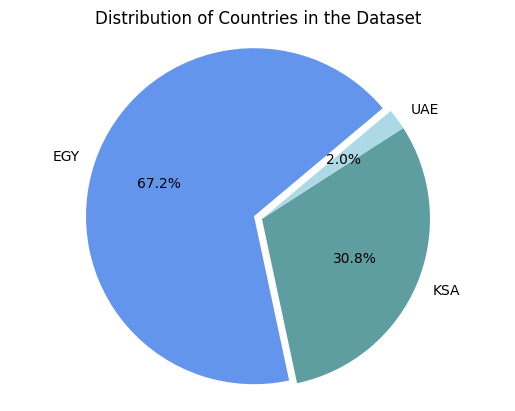

In [ ]:
country_count = df['COUNTRY'].value_counts()
mycolors = ['cornflowerblue', 'cadetblue', 'lightblue']

plt.pie(country_count, explode = (0.05, 0, 0), labels = ['EGY', 'KSA', 'UAE'], colors = mycolors, autopct = '%1.1f%%', shadow = False, startangle = 40)
plt.title('Distribution of Countries in the Dataset')
plt.axis('equal')
plt.show()


The data from the three countries is heterogenous, i.e. addresses have different formats and structures. Thereby, we decided to focus on Egypt for it being the primary market of Taager and representing the bigger proportion of our dataset.

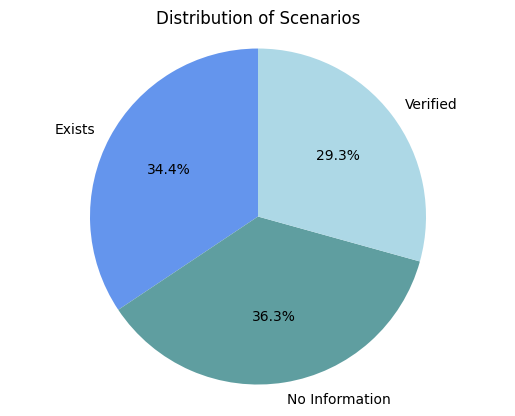

In [ ]:
scenario_counts = {
    "Exists": ((df['IS_CONFIRMED'] == 1) & (df['IS_DELIVERED'] == 1)).sum(),
    "No Information": ((df['IS_CONFIRMED'] == 0) & (df['IS_DELIVERED'] == 0)).sum(),
    "Verified": ((df['IS_CONFIRMED'] == 1) & (df['IS_DELIVERED'] == 0)).sum()
}
mycolors = ['cornflowerblue', 'cadetblue', 'lightblue']
plt.pie(scenario_counts.values(), labels=scenario_counts.keys(),  colors = mycolors, autopct = '%1.1f%%', shadow = False, startangle = 90, explode = (0, 0., 0.))
plt.title('Distribution of Scenarios')
plt.axis('equal')
plt.show()

# Egypt Data

In [ ]:
# Filter Data on Egypt
df_egy = df.loc[df['COUNTRY'] == 'EGY']
# Drop irrelevant columns
df_egy = df_egy.drop(['ORDER_ID','COUNTRY','RECEPTION_CHANNEL'], axis =1)

Since we can't get any insights from addresses that were not confirmed, we opted for dropping them

In [ ]:
# Filter out is confirmed = is delivered = 0
df_egy = df_egy[df_egy['IS_CONFIRMED'] != 0]

We added a new column to check the similarity between the initial and final addresses

In [ ]:
df_egy['IS_SIMILAR'] = df_egy.apply(lambda row: 1 if row['INITIAL_ADDRESS'] == row['LATEST_ADDRESS'] else 0, axis=1)

# If similar, we keep the latest address and labelize to 1
similar_address = df_egy[df_egy['IS_SIMILAR']==1][['LATEST_ADDRESS']]
similar_address['Label'] = 1

# If not similar, the latest address is labelized to 1
valid_address = df_egy[df_egy['IS_SIMILAR']==0][['LATEST_ADDRESS']]
valid_address['Label'] = 1

# If not similar, the initial address is labelized to 0
not_valid_address = df_egy[df_egy['IS_SIMILAR']==0][['INITIAL_ADDRESS']]
not_valid_address['Label'] = 0

# Renaming columns
similar_address = similar_address.rename(columns={'LATEST_ADDRESS': 'Address'})
valid_address = valid_address.rename(columns={'LATEST_ADDRESS': 'Address'})
not_valid_address = not_valid_address.rename(columns={'INITIAL_ADDRESS': 'Address'})

# Concatenating the dataframes
transformed_df = pd.concat([similar_address, valid_address, not_valid_address], ignore_index=True)

# Data Cleaning

For data cleaning, the steps are removing:
1. Duplicates
2. Missing Values
3. Special Characters
4. Latin Addresses

In [ ]:
# Function to remove special characters from a string
def remove_latin_and_special(text):
    # Define a regular expression pattern to match Latin words and special characters
    pattern = r'[a-zA-Z]|[^a-zA-Z0-9\s\p{Arabic}]'
    # Use the re.sub() method to replace these characters with an empty string
    cleaned_text = re.sub(pattern, ' ', text)

    # Replace numeric values with 'رقم'
    #cleaned_text = re.sub(r'\d+', ' رقم ', cleaned_text)

    return cleaned_text

In [ ]:
#Cleaning function
def transform_df(dataframe):
  df = dataframe.copy()
  #Remove duplicates
  df = df.drop_duplicates(subset=['Address'])
  #Remove missing rows
  df = df.dropna(subset=['Address'])
  #Remove text with number of caracters <= 2
  df = df[df['Address'].str.len()>=3]
  #Remove Latin words and special characters
  df['Address'] = df['Address'].apply(remove_latin_and_special)
  #Remove rows that contain only space
  df = df[df['Address'].str.strip() != '']
  #Remove rows that contain only numeric values
  df = df[~df['Address'].str.replace(' ', '').str.isnumeric()]
  #Replace numbers characters with ' رقم '
  df['Address'] = df['Address'].apply(lambda x : re.sub(r'\d+', ' رقم ', x))
  #Drop new duplicates
  df = df.drop_duplicates(subset=['Address'])
  #Add column to compute address lenght
  df['Address_len'] = df['Address'].apply(lambda x:len(x.split()))
  return df

In [ ]:
final_df = transform_df(transformed_df)
final_df.shape

(282628, 3)

In [ ]:
final_df['Address_len'].describe()

count    282628.000000
mean         12.185307
std           5.201367
min           1.000000
25%           9.000000
50%          12.000000
75%          15.000000
max         171.000000
Name: Address_len, dtype: float64

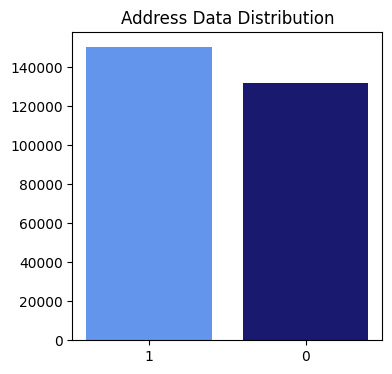

In [ ]:
#Checking if data is Balanced
val_count = final_df.Label.value_counts()
plt.figure(figsize=(4,4))
plt.bar(['1', '0'], val_count.values, color = ['cornflowerblue', 'midnightblue'], align = 'center')
plt.title("Address Data Distribution")
plt.show()

We observe that our data is balanced

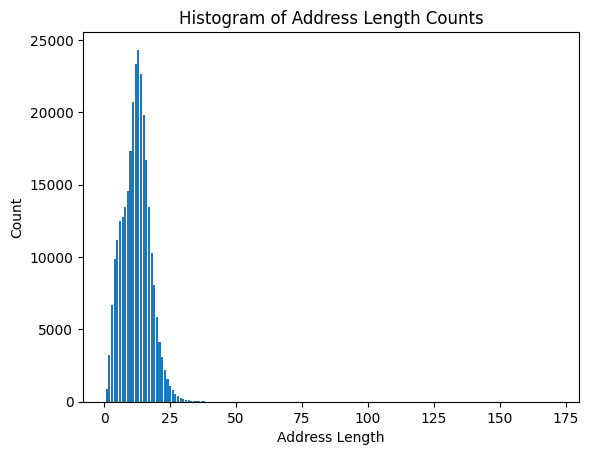

In [ ]:
words_count = final_df["Address_len"].value_counts()
plt.bar(words_count.index, words_count)
plt.xlabel("Address Length")
plt.ylabel("Count")
plt.title("Histogram of Address Length Counts")
plt.show()

<Axes: xlabel='Label', ylabel='Address_len'>

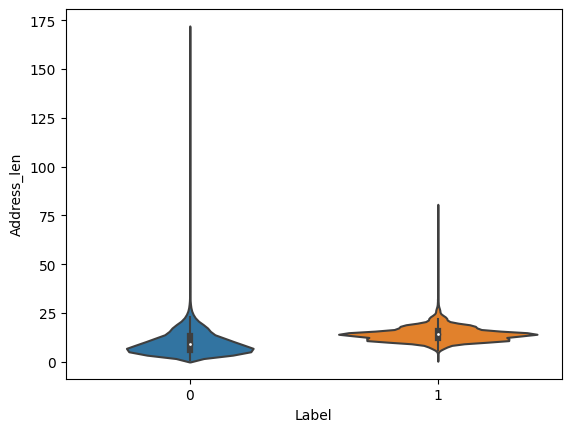

In [ ]:
sns.violinplot(x=final_df.Label, y=final_df.Address_len)

In [ ]:
final_df.head()

,Address,Label,Address_len
0,شارع صلاح الدين أمام عمارات المرشدى فوق أسواق ...,1,14
1,مدينة نصر امام نادى المقاولون العرب عمارة رقم...,1,23
2,اسوان ادفو الكلح شرق الشهيد صلاح نصر بجوار الم...,1,10
3,ش عربى عبدالواحد الترعه السلطوحية الدور رقم ...,1,16
4,رقم شارع الروضه المنيل فوق مطعم اسماك البحري...,1,12


In [ ]:
final_df[['Address', 'Label']].to_csv('Preprocessed_data.csv', index=False)